#  Прогнозирование заказов такси

**Описание исследования:**

Компания «Чётенькое такси» собрала данные о заказах такси в аэропортах. Цель исследования – построить модель для прогнозирования количества заказов такси на следующий час с использованием исторических данных.

**Цель исследования:**

Разработать модель для предсказания числа заказов такси на следующий час с помощью машинного обучения и оценить её точность по метрике RMSE.

**Суть исследования:**

Анализируем данные о заказах такси, ресемплируем их по одному часу, обучаем различные модели и оцениваем их производительность.

**Задачи исследования:**

1) Загрузить и подготовить данные.

2) Проанализировать и очистить данные (поиск пропусков, аномалий и ошибок).

3) Построить несколько моделей машинного обучения (LightGBM, DecisionTreeRegressor, CatBoost, RandomForestRegressor).

4) Проверить точность моделей на тестовой выборке и выбрать лучшую модель для прогнозирования.

**Исходные данные:**

Данные находятся в файле taxi.csv. Основной столбец, интересующий нас, это num_orders (число заказов).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

<h1>Импорт библиотек, функций и констант<span class="tocSkip"></span></h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, train_test_split

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def liner(data, title, xlabel='X', ylabel='Y'):
    """
    Строит линейный график с заданными данными и заголовком.

    Параметры:
    - data: Данные для построения графика (pandas Series или DataFrame)
    - title: Заголовок графика
    - xlabel: Метка для оси X (по умолчанию 'X')
    - ylabel: Метка для оси Y (по умолчанию 'Y')
    """
    sns.set(rc={'figure.figsize':(15,4)})
    data.plot()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [3]:
def make_features(data, max_lag, rolling_mean_size):
    """
    Создаёт дополнительные признаки для временного ряда: лаги, день недели, день месяца и скользящее среднее.

    Параметры:
    - data: pd.DataFrame — Исходные данные с индексом в формате datetime
    - max_lag: int — Максимальное количество лагов для добавления
    - rolling_mean_size: int — Размер окна для вычисления скользящего среднего

    Возвращает:
    - pd.DataFrame — Данные с добавленными признаками.
    """
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data.dropna(inplace=True)

    return data

In [4]:
def display_result(target, pred, rmse):
    result = target[['datetime']].copy()
    result['prediction'] = pred
    result.set_index('datetime', inplace=True)
    
    print(f"RMSE: {rmse}")
    
    liner(result, 'RMSE=' + str(rmse))

    return result

In [5]:
RANDOM_STATE = 42
tss_cv = TimeSeriesSplit(gap=0, max_train_size=1000, n_splits=3, test_size=1000)

## Подготовка

Читаем файл, назначив даты индексом

In [6]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

data.sort_index(inplace=True)

Посмотрим первые 5 сторк и общую информацию

In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим индексы на монотонность

In [9]:
data.index.is_monotonic

True

Проверим фрейм на пропуски

In [10]:
data.isna().sum()

num_orders    0
dtype: int64

Ресемплируем данные по часу и по дню

In [11]:
data_day = data.copy()

data_day = data_day.resample('1D').sum()

data = data.resample('1H').sum()

## Анализ

Разложим временной ряд на трендовую и сезонную компоненту, проанализируем каждую из них

In [12]:
decomposed = seasonal_decompose(data)

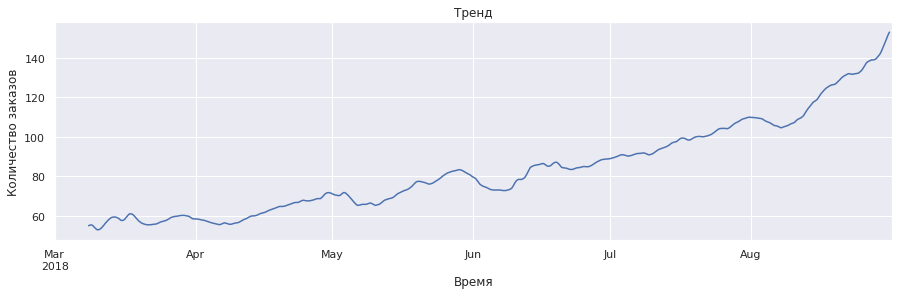

In [13]:
liner(decomposed.trend.rolling(24*7).mean(), 'Тренд', xlabel='Время', ylabel='Количество заказов')

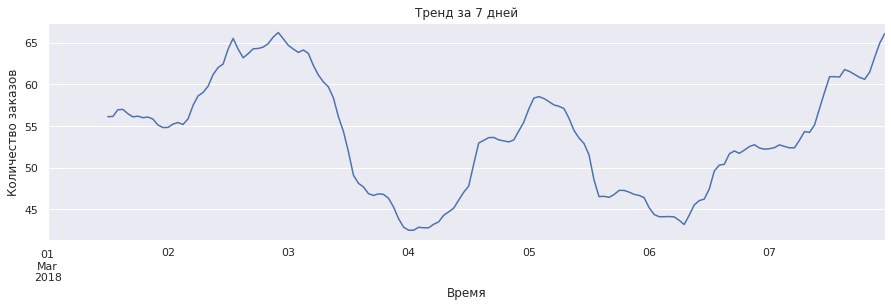

In [14]:
liner(decomposed.trend.head(24*7), 'Тренд за 7 дней', xlabel='Время', ylabel='Количество заказов')

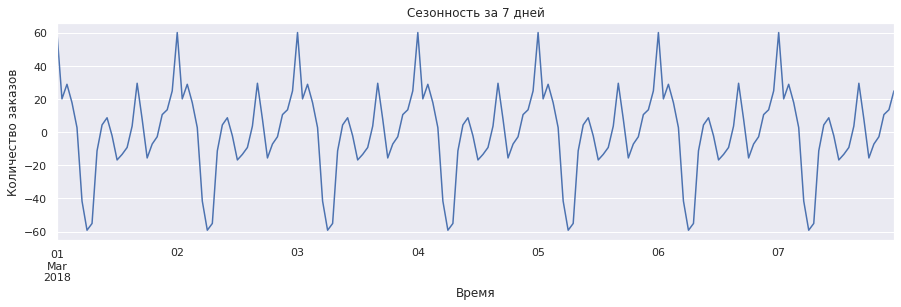

In [15]:
liner(decomposed.seasonal.head(24*7), 'Сезонность за 7 дней', xlabel='Время', ylabel='Количество заказов')

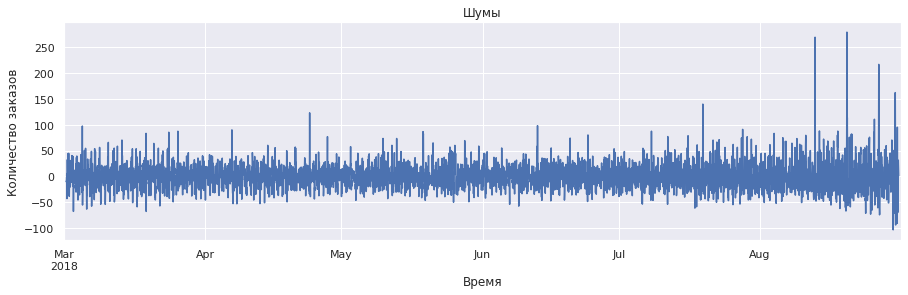

In [16]:
liner(decomposed.resid, 'Шумы', xlabel='Время', ylabel='Количество заказов')

Выводы:

- Наблюдается общий тренд на увеличение количество заказов

- Присутствует сезонность, а именно: c 00:00 наблюдается спад количества заказов примерно до 6 утра, после чего количество заказов начинает расти. Самый пик приходится с 22 до 23.

In [17]:
day_decomposed = seasonal_decompose(data_day)

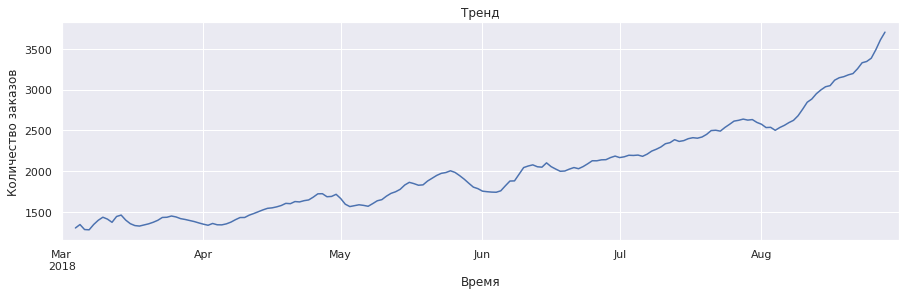

In [18]:
liner(day_decomposed.trend, 'Тренд', xlabel='Время', ylabel='Количество заказов')

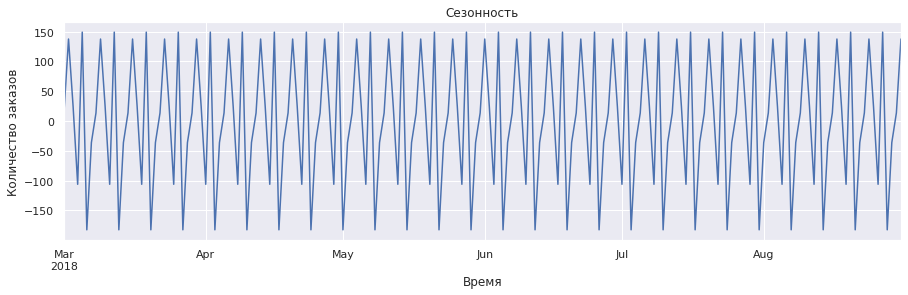

In [19]:
liner(day_decomposed.seasonal, 'Сезонность', xlabel='Время', ylabel='Количество заказов')

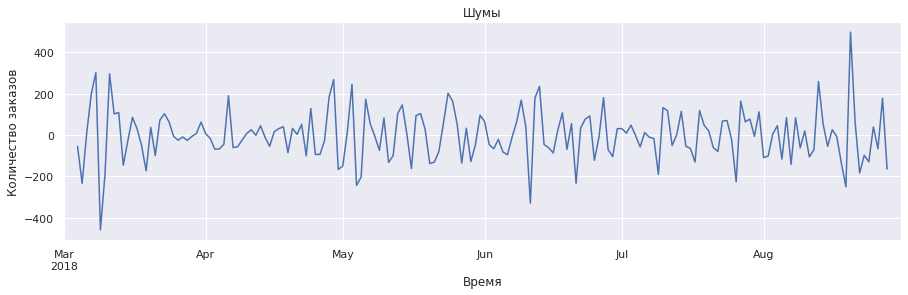

In [20]:
liner(day_decomposed.resid, 'Шумы', xlabel='Время', ylabel='Количество заказов')

## Обучение

Создадим датафрейм с признаками для горизонта прогнозирования в один шаг

In [21]:
data_features = data.copy()

data_features = make_features(data_features, 7, 3)

Проверим размерности исходного датафрейма и датафрейма с признаками

In [22]:
data.shape

(4416, 1)

In [23]:
data_features.shape

(4409, 12)

Разделим данные на тренировочную и тестовые выборки

In [24]:
train, test = train_test_split(data_features, shuffle=False, test_size=0.1)

In [25]:
train_target = train['num_orders']
train_features = train.drop('num_orders', axis=1)

test_target = test['num_orders']
test_features = test.drop('num_orders', axis=1)

In [26]:
models = []
rmse_cross = []

### LightGBM

In [27]:
train_features_lgb = train_features.copy()
test_features_lgb = test_features.copy()

In [28]:
pipeline = Pipeline(steps=[
    ('preprocessor', Pipeline(steps=[
        ('simpleImputer_num', SimpleImputer(strategy='median'))
    ])),
    ('lgbmr', LGBMRegressor(random_state=42, n_estimators=150))
])

param_grid = {
    'lgbmr__num_leaves': [10, 20, 30],
    'lgbmr__learning_rate': [0.01, 0.05],
    'lgbmr__max_depth': [-1, 5, 10, 15]
}

In [29]:
clf = RandomizedSearchCV(pipeline,
                                   param_distributions=param_grid,
                                   n_iter=5,
                                   cv=tss_cv, 
                                   scoring='neg_mean_squared_error',
                                   random_state=RANDOM_STATE,
                                   n_jobs=-1)

clf.fit(train_features_lgb, train_target)

rmse_lgbm_cv = (-clf.best_score_) ** 0.5
print("Замеряем RMSE на кросс-валидации:", rmse_lgbm_cv)

model_lgbm = clf.best_estimator_

models.append(model_lgbm)
rmse_cross.append(rmse_lgbm_cv)

Замеряем RMSE на кросс-валидации: 27.40701938253634


### DecisionTreeRegressor

In [30]:
pipeline = Pipeline(steps=[
    ('preprocessor', Pipeline(steps=[
        ('simpleImputer_num', SimpleImputer(strategy='median'))
    ])),
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42))
])

param_dist = {
    'DecisionTreeRegressor__max_depth': range(2, 20),
    'DecisionTreeRegressor__min_samples_split': range(2, 10),
    'DecisionTreeRegressor__min_samples_leaf': range(1, 10)
}

In [31]:
random_search = RandomizedSearchCV(pipeline,
                                   param_distributions=param_dist,
                                   n_iter=5,
                                   cv=tss_cv, 
                                   scoring='neg_mean_squared_error',
                                   random_state=RANDOM_STATE,
                                   n_jobs=-1
                                  )

random_search.fit(train_features, train_target)

rmse_tree_cv = (-random_search.best_score_) ** 0.5
print("Замеряем RMSE на кросс-валидации:", rmse_tree_cv)

model_tree =random_search.best_estimator_

models.append(model_tree)
rmse_cross.append(rmse_tree_cv)

Замеряем RMSE на кросс-валидации: 29.374595018705225


### CatBoost

In [32]:
pipeline = Pipeline(steps=[
    ('preprocessor', Pipeline(steps=[
        ('simpleImputer_num', SimpleImputer(strategy='median'))
    ])),
    ('CatBoostRegressor', CatBoostRegressor(random_state=42, verbose=0))
])

param_dist = {
    'CatBoostRegressor__depth': [3, 5, 7],
    'CatBoostRegressor__learning_rate': [0.1, 0.2],
}

In [33]:
random_cat = RandomizedSearchCV(pipeline,
                                   param_distributions=param_dist,
                                   n_iter=3,
                                   cv=tss_cv, 
                                   scoring='neg_mean_squared_error',
                                   random_state=RANDOM_STATE,
                                   n_jobs=-1)

random_cat.fit(train_features, train_target)

rmse_catboost_cv = (-random_cat.best_score_) ** 0.5
print("Замеряем RMSE на кросс-валидации для CatBoost:", rmse_catboost_cv)

model_catboost = random_cat.best_estimator_

models.append(model_catboost)
rmse_cross.append(rmse_catboost_cv)

Замеряем RMSE на кросс-валидации для CatBoost: 27.715056072841676


In [34]:
results = []

for model, rmse in zip(models, rmse_cross):
    
    model_name = type(model.steps[-1][1]).__name__
    
    results.append({"Model": model_name, "RMSE": rmse})

results_df = pd.DataFrame(results)

In [35]:
models

[Pipeline(steps=[('preprocessor',
                  Pipeline(steps=[('simpleImputer_num',
                                   SimpleImputer(strategy='median'))])),
                 ('lgbmr',
                  LGBMRegressor(learning_rate=0.05, max_depth=5,
                                n_estimators=150, num_leaves=20,
                                random_state=42))]),
 Pipeline(steps=[('preprocessor',
                  Pipeline(steps=[('simpleImputer_num',
                                   SimpleImputer(strategy='median'))])),
                 ('DecisionTreeRegressor',
                  DecisionTreeRegressor(max_depth=13, min_samples_leaf=9,
                                        min_samples_split=6, random_state=42))]),
 Pipeline(steps=[('preprocessor',
                  Pipeline(steps=[('simpleImputer_num',
                                   SimpleImputer(strategy='median'))])),
                 ('CatBoostRegressor',
                  <catboost.core.CatBoostRegressor object at 0x

In [36]:
results_df.sort_values(by='RMSE')

,Model,RMSE
0,LGBMRegressor,27.407019
2,CatBoostRegressor,27.715056
1,DecisionTreeRegressor,29.374595


На основании полученных результатов, **LGBMRegressor** продемонстрировал наилучший результат по метрике RMSE с ошибкой **27.41**, что делает его лидером среди рассмотренных моделей. Следующими по эффективности идут **CatBoostRegressor (27.72)** и **DecisionTreeRegressor (29.37).**

Таким образом, с учётом полученных результатов, мы можем с уверенностью приступить к тестированию **LGBMRegressor** на тестовой выборке для более точной оценки её производительности.

## Тестирование

Протестируем лучшую модель кросс-валидации на тестовой выборке.

In [37]:
best_model_predictions = model_lgbm.predict(test_features)

rmse_model = np.sqrt(mean_squared_error(test_target, best_model_predictions))

print(f"RMSE для LightGBM: {rmse_model}")

RMSE для LightGBM: 46.64206770766998


Вывод: по результатам исселедования лучшей моделью окаалсь **LGBMRegressor** с результатом в **46.64**